In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Latent matrix from metadata

In [2]:
!ls ../data

2019-Dec.csv_10%.csv 2019-Oct.csv_10%.csv


In [3]:
filename_1 = '../data/2019-Oct.csv_10%.csv'

In [4]:
p = 0.01 #1% of the lines

In [5]:
%%time

# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df_1 = pd.read_csv(
         filename_1,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df_1.shape

CPU times: user 2.35 s, sys: 63.9 ms, total: 2.41 s
Wall time: 2.42 s


(42232, 9)

In [6]:
filename_2 = '../data/2019-Dec.csv_10%.csv'

In [7]:
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df_2 = pd.read_csv(
         filename_2,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df_2.shape

(67042, 9)

In [8]:
df = pd.concat([df_1, df_2], axis=0)

In [9]:
df.shape

(109274, 9)

In [10]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [11]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:01:11 UTC,view,1004836,2053013555631882655,electronics.smartphone,samsung,241.19,546259103,6e2984c8-502e-4fe7-bbba-34087f760175
1,2019-10-01 02:19:20 UTC,view,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,540951424,a674d0c1-9b0e-4387-8281-112a5f893a45
2,2019-10-01 02:19:37 UTC,view,5100816,2053013553375346967,NaN,xiaomi,29.51,513076189,aaeeadd7-2a2a-437e-91a0-9455695c8cf7
3,2019-10-01 02:24:36 UTC,view,9000129,2053013566067311601,NaN,janome,283.12,554179455,811eaa71-283f-4689-8943-dfca0cef15d5
4,2019-10-01 02:25:41 UTC,view,7005315,2053013560346280633,kids.carriage,belecoo,101.89,518617421,d78beff4-7a3e-4128-b875-22fee6c28b99


In [12]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [13]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/var/folders/p5/qt42vq_56xz89lxgtq0ygbdh0000gn/T/ipykernel_13211/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [14]:
X_preprocessed.shape

(79775, 8)

## Pricing criterion

In [15]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [16]:
X_merged = pricing_criterion(X_preprocessed)

In [17]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [18]:
X_meta = metadata(X_merged)
X_meta.nunique()

event_type            3
product_id        20225
category_id         745
category_code       134
brand              2059
price             16167
user_id           76141
user_session      79326
25%                 131
75%                 132
price_category        3
metadata           6971
dtype: int64

In [19]:
%%time 

X_meta.set_index(X_meta['product_id'], inplace=True)

CPU times: user 208 µs, sys: 374 µs, total: 582 µs
Wall time: 587 µs


In [20]:
print(X_meta.shape)
X_meta.head()

(79775, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
49800019,view,49800019,2126679654801604876,accessories bag,ritmix,3.93,518844542,7e2e01b1-8936-4f08-ae8a-70d431e1ba88,24.795,75.545,low,accessories bag ritmix low
28400775,view,28400775,2053013566209917945,accessories bag,baden,61.52,550019201,f2b749f5-928b-4402-a9b5-79c56f53070a,24.795,75.545,medium,accessories bag baden medium
28400775,view,28400775,2053013566209917945,accessories bag,baden,61.52,537339865,6988de7a-451b-4079-a8f8-4ee931817b10,24.795,75.545,medium,accessories bag baden medium
18300155,view,18300155,2053013558945383017,accessories bag,lenovo,10.27,532269310,2137a699-27cf-4356-969f-e631495979d2,24.795,75.545,low,accessories bag lenovo low
18300185,view,18300185,2053013558945383017,accessories bag,xiaomi,48.14,525959286,7e5ec397-19cc-4ab2-a41e-78bf384b2939,24.795,75.545,medium,accessories bag xiaomi medium


### Count Vectorizer

In [21]:
%%time

count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)
count_df_1.head()

(79775, 2243)
CPU times: user 527 ms, sys: 176 ms, total: 703 ms
Wall time: 702 ms


,0,1,2,3,4,5,6,7,8,9,...,2233,2234,2235,2236,2237,2238,2239,2240,2241,2242
49800019,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28400775,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28400775,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18300155,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18300185,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
%%time 
count_df_1 = count_df_1.reset_index()

CPU times: user 2.1 s, sys: 534 ms, total: 2.64 s
Wall time: 2.63 s


In [23]:
len(list(set(count_df_1.index)))#.nunique()

79775

In [24]:
%%time
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

CPU times: user 986 ms, sys: 866 ms, total: 1.85 s
Wall time: 1.85 s


,0,1,2,3,4,5,6,7,8,9,...,2234,2235,2236,2237,2238,2239,2240,2241,2242,product_id
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800019
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28400775
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18300155
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18300185
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32900068


### Dimensionality reduction

In [25]:
%%time
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

CPU times: user 28.6 s, sys: 6.21 s, total: 34.8 s
Wall time: 6.86 s


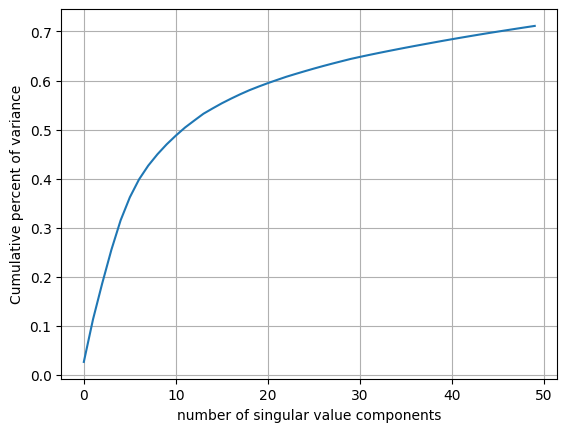

In [26]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [27]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

In [28]:
%%time
#n defined above
#n = 50

latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

(20225, 50)
CPU times: user 4.04 ms, sys: 212 µs, total: 4.25 ms
Wall time: 4.01 ms


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
49800019,0.262088,0.339013,0.575642,-0.626847,-0.104614,0.109373,0.230494,0.166161,0.693743,0.758292,...,0.002027,0.009693,0.016109,0.003834,0.003203,0.007872,0.012346,0.002516,0.013316,0.017429
28400775,0.790758,-0.474472,-0.288409,-0.100782,0.147691,0.114980,0.186058,0.163036,0.685110,0.746779,...,-0.045156,0.063024,-0.057578,-0.016387,-0.024016,-0.000629,-0.010528,0.022457,0.009609,0.019020
18300155,0.272511,0.336338,0.575675,-0.621270,-0.087459,0.114309,0.274810,0.146147,0.668414,0.754379,...,0.050110,-0.153264,-0.138710,-0.016260,-0.046052,-0.115944,-0.007798,0.096187,-0.118133,-0.022845
18300185,0.805352,-0.460479,-0.291972,-0.131059,0.184888,0.158298,0.161986,0.171294,0.682467,0.735631,...,-0.086125,0.111288,0.147393,0.106032,0.017451,0.003264,0.058128,0.054068,0.001857,0.036379
32900068,0.260607,0.336915,0.571095,-0.621653,-0.104654,0.110015,0.226776,0.163911,0.691626,0.753133,...,0.001795,0.013198,0.016454,0.008078,0.001901,0.007192,0.017183,0.000020,0.012273,0.020482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12900813,0.205545,0.333499,0.548577,-0.611558,-0.153617,0.062923,0.127951,0.050844,0.117686,0.017077,...,-0.007783,0.003709,-0.013434,0.047159,0.005538,0.007573,-0.008470,-0.014688,0.015456,-0.015403
16600281,0.724603,-0.464003,-0.319705,-0.098186,0.109517,0.071234,0.088982,0.052013,0.113342,0.007084,...,0.000156,0.010058,-0.026104,0.042984,0.008028,0.000357,-0.003918,-0.008648,0.006443,-0.017572
25510293,0.206265,0.333715,0.549188,-0.612032,-0.153492,0.063374,0.129077,0.055943,0.118999,0.013919,...,-0.010598,0.005905,-0.011945,0.048430,0.002204,0.007318,-0.007767,-0.013312,0.015100,-0.013255
36200044,0.725189,-0.463352,-0.320130,-0.097765,0.109667,0.072085,0.088479,0.052906,0.113228,0.008245,...,-0.004335,0.004414,-0.023880,0.035956,0.005585,0.002653,0.000819,-0.007089,0.008663,-0.017049


In [29]:
%%time

latent_df_1.reset_index().drop_duplicates().shape

CPU times: user 47.2 ms, sys: 7.27 ms, total: 54.5 ms
Wall time: 55.7 ms


(20225, 51)

In [30]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [31]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [32]:
df_event = preprocessing_event(df)
df_event.user_id.nunique()

76141

In [33]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [34]:
df_event['rating'] = df_event['event_type'].map(dct)

In [35]:
df_event["rating"].sum()

93217

In [36]:
# df_rating.shape

In [37]:
# df_rating = df_event.pivot_table(values='rating',
#                                  index='product_id',
#                                  columns='user_id',
#                                  aggfunc="sum").fillna(0)
# df_rating

In [38]:
df_event.nunique()

event_time       78930
event_type           3
product_id       20225
category_id        745
category_code      134
brand             2059
price            16167
user_id          76141
user_session     79326
rating               3
dtype: int64

In [39]:
%%time

df_event.drop_duplicates(subset='product_id',inplace=True)
df_event.nunique()

CPU times: user 21.7 ms, sys: 2.84 ms, total: 24.6 ms
Wall time: 22.6 ms


event_time       20169
event_type           3
product_id       20225
category_id        744
category_code      134
brand             2059
price             7933
user_id          19654
user_session     20141
rating               3
dtype: int64

In [40]:
%%time

df_rating = df_event.pivot(values='rating',
               index='product_id',
               columns='user_id').fillna(0)

df_rating

CPU times: user 2.41 s, sys: 1.76 s, total: 4.16 s
Wall time: 4.16 s


user_id,240911063,350988072,353711846,364250590,380442790,382634185,417230237,419202861,430212017,430276841,...,595206140,595221543,595227626,595276379,595297580,595306228,595321817,595368519,595392342,595398418
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100062443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100062459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100062484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df_rating.sum().reset_index()[0].sum()

21741.0

In [42]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    21741
dtype: int64

In [43]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    21741
dtype: int64

In [44]:
df_rating.reset_index()

user_id,product_id,240911063,350988072,353711846,364250590,380442790,382634185,417230237,419202861,430212017,...,595206140,595221543,595227626,595276379,595297580,595306228,595321817,595368519,595392342,595398418
0,1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1001605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1001606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1001618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220,100062443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20221,100062459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20222,100062484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20223,100063161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
%%time

svd = TruncatedSVD(n_components=2000)
latent_df_2 = svd.fit_transform(df_rating)

CPU times: user 12min 26s, sys: 16.7 s, total: 12min 42s
Wall time: 1min 43s


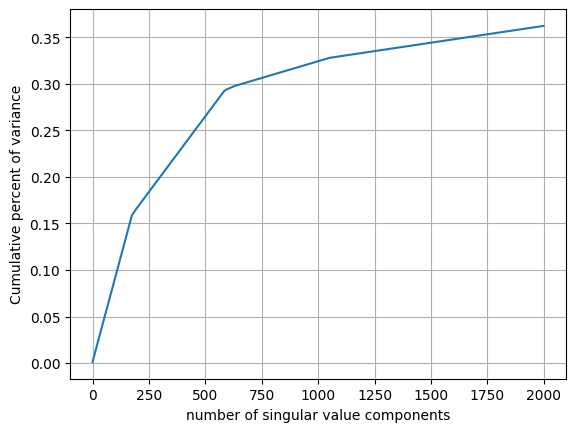

In [46]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [47]:
%%time

latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

CPU times: user 5.72 s, sys: 1.12 s, total: 6.84 s
Wall time: 6.84 s


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1000978,2.369917e-12,-6.014125e-11,9.424617e-11,5.936337e-11,3.208815e-11,-1.317444e-12,1.140884e-11,5.098365e-11,-7.374644e-11,-7.967094e-11,...,-0.007645,-0.004501,0.004642,-0.002324,0.004976,0.002805,0.013416,0.000975,-0.007842,-0.018176
1001588,1.518533e-11,-1.521648e-10,1.371119e-10,2.505774e-11,6.222722e-11,2.410543e-12,7.539118e-11,-1.528434e-11,-1.162362e-12,6.350634e-11,...,0.003274,-0.001258,0.012933,0.003900,0.003688,-0.003999,-0.004081,-0.004518,-0.000026,-0.002716
1001605,5.086502e-12,-5.168976e-11,-6.924871e-11,3.429219e-11,1.521324e-10,-2.959383e-11,1.981980e-11,1.324456e-10,6.283411e-11,1.230065e-10,...,0.011834,-0.003446,0.004799,-0.013402,0.023982,-0.008296,-0.007728,0.005928,-0.006713,0.007150
1001606,3.904403e-12,6.327400e-12,-2.683428e-10,1.194816e-10,-6.877956e-11,6.518097e-11,4.856701e-11,-9.427176e-11,-7.411661e-11,-8.968337e-11,...,0.013680,0.011976,0.001442,0.002489,-0.003835,-0.003776,-0.002630,-0.012024,-0.009501,0.002815
1001618,-3.070240e-11,-6.495168e-11,-5.186236e-11,2.194779e-10,4.785887e-11,1.164130e-10,-3.302325e-11,8.168189e-12,2.885091e-12,-9.641884e-11,...,-0.001681,0.004711,-0.005279,-0.003003,0.001898,0.005080,0.002001,0.006796,0.004480,-0.001170


In [48]:
latent_df_2.shape

(20225, 2000)

# Apply Cosine Similarity in Content and Collaborative Matrices


In [49]:
product_id=5100337

In [50]:
%%time
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[product_id]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[product_id]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

CPU times: user 938 ms, sys: 256 ms, total: 1.19 s
Wall time: 223 ms


In [51]:
dictDf_1 = {'features': sim1} 
recommendation_df_1 = pd.DataFrame(dictDf_1, index = latent_df_1.index)
# recommendation_df_1.sort_values('features', ascending=False, inplace=True)

In [52]:
dictDf_2 = {'ratings': sim2} 
recommendation_df_2 = pd.DataFrame(dictDf_2, index = latent_df_2.index)
# recommendation_df_2.sort_values('ratings', ascending=False, inplace=True)

In [53]:
weight_features = 0.8

In [54]:
%%time
recommendation_combined = pd.merge(recommendation_df_1, recommendation_df_2, left_index=True, right_index=True)
recommendation_combined['hybrid'] = ((weight_features*recommendation_combined['features'] + (1-weight_features)*recommendation_combined['ratings']))

CPU times: user 27.2 ms, sys: 14.8 ms, total: 42 ms
Wall time: 5.33 ms


In [55]:
recommendation_combined.sort_values('ratings', ascending=False, inplace=True)
recommendation_combined

,features,ratings,hybrid
5100337,1.000000,1.000000,1.000000
13200969,0.255701,0.118426,0.228246
26600551,0.001102,0.117718,0.024425
6301540,0.259282,0.115963,0.230618
100017765,0.243457,0.104973,0.215760
...,...,...,...
12200998,0.003185,-0.116947,-0.020841
1004790,0.248331,-0.118431,0.174978
1802142,0.518095,-0.118596,0.390757
100022149,0.581074,-0.123736,0.440112


In [56]:
recommendation_combined.head()

,features,ratings,hybrid
5100337,1.000000,1.000000,1.000000
13200969,0.255701,0.118426,0.228246
26600551,0.001102,0.117718,0.024425
6301540,0.259282,0.115963,0.230618
100017765,0.243457,0.104973,0.215760


In [57]:
def top_n_products(product_id, rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inouts for ranking: 'features', 'ratings', 'hybrid'"""
    
    feat_idx = rec_df.sort_values(ranking, ascending=False).index[0:n]
    counter = 0
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        
        if counter == 0:
            print(f"Top {n} recommendations for product_id {product_id}:")
            print(f"{i} - {meta_text} \n")
#             print("-----------------------")

        else:
            print(f"Rec {counter}) {i} - {meta_text}")
        
        counter += 1

In [58]:
top_n_products(1002532, recommendation_combined, X_meta, n=100, ranking='features')

Top 100 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 5100343 - electronics clocks apple medium
Rec 2) 5100346 - electronics clocks apple medium
Rec 3) 5100505 - electronics clocks apple medium
Rec 4) 5100067 - electronics clocks apple medium
Rec 5) 5100351 - electronics clocks apple medium
Rec 6) 5100562 - electronics clocks apple medium
Rec 7) 5100610 - electronics clocks apple medium
Rec 8) 3900775 - electronics clocks artel medium
Rec 9) 3900776 - electronics clocks artel medium
Rec 10) 3900743 - electronics clocks horizont medium
Rec 11) 3900808 - electronics clocks shivaki medium
Rec 12) 100015396 - electronics clocks triumphtree medium
Rec 13) 100015270 - electronics clocks triumphtree medium
Rec 14) 3901190 - electronics clocks aqua medium
Rec 15) 3900945 - electronics clocks klima medium
Rec 16) 48300099 - electronics clocks silverlit medium
Rec 17) 100006757 - electronics clocks silverlit medium
Rec 18) 3900381 - electronics clocks

In [59]:
top_n_products(1002532, recommendation_combined, X_meta, n=100, ranking='ratings')

Top 100 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 13200969 - furniture bedroom bed bts medium
Rec 2) 26600551 - apparel shoes lucente low
Rec 3) 6301540 - appliances kitchen kettle galaxy medium
Rec 4) 100017765 - appliances kitchen hood bosch medium
Rec 5) 21409486 - electronics clocks casio medium
Rec 6) 1003938 - electronics smartphone meizu medium
Rec 7) 4100259 - apparel shoes sony high
Rec 8) 2501143 - appliances kitchen oven artel low
Rec 9) 100026282 - sport ski jade high
Rec 10) 15500332 - apparel underwear veston low
Rec 11) 21401186 - electronics clocks casio high
Rec 12) 11000096 - appliances kitchen grill bosch medium
Rec 13) 8700151 - appliances personal hair_cutter scarlett low
Rec 14) 17302626 - apparel shoes sandals chanel high
Rec 15) 23201023 - construction tools saw dox low
Rec 16) 28102882 - apparel pajamas urgaz medium
Rec 17) 21400931 - electronics clocks casio low
Rec 18) 5700791 - auto accessories player sony low

In [60]:
top_n_products(1002532, recommendation_combined, X_meta, n=100, ranking='hybrid')

Top 100 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 5100343 - electronics clocks apple medium
Rec 2) 5100562 - electronics clocks apple medium
Rec 3) 5100346 - electronics clocks apple medium
Rec 4) 5100505 - electronics clocks apple medium
Rec 5) 5100067 - electronics clocks apple medium
Rec 6) 5100351 - electronics clocks apple medium
Rec 7) 5100610 - electronics clocks apple medium
Rec 8) 100012058 - electronics clocks claudebernard medium
Rec 9) 21405945 - electronics clocks dkny medium
Rec 10) 21400091 - electronics clocks boccia medium
Rec 11) 21411335 - electronics clocks seiko medium
Rec 12) 21405118 - electronics clocks armani medium
Rec 13) 100015096 - electronics clocks triumf medium
Rec 14) 21405659 - electronics clocks fossil medium
Rec 15) 21405843 - electronics clocks versus medium
Rec 16) 100009789 - electronics clocks adriatica medium
Rec 17) 10600488 - electronics clocks matrol medium
Rec 18) 21405264 - electronics clocks

In [ ]:
## -------- FLOW OF CROSS-SELLING FEATURE -----------------------

# ---------------------- INDIVIDUAL USER -----------------------

# 1. Groupby "User session id"
    # 100 
# 2. Filter by "user sessions" that have "2 + bought producst"
    # 10 -> 2+ Products
# 3. Matrix that has combination of products
    # Look at the most common combinations (numeric) & rank the matrix in that order
    

# ---------------------- NEW USER -----------------------

# 1. Select one product & Add to my cart
# 2. Algo looks on the matrix of Prod_combinations
    # matches the current product in the basket
    # provides that as cross-selling product -> according to the "most common combination"
        

